## Perform the first step of the Two-step Engle-Granger Cointegration Test

We consider two series of equity prices $Y_{t}$ and $X_{t}$ as a time series conforming to the expression:
$ Y_{t} = \alpha + \beta X_{t} + \epsilon_{t} $, where $\alpha$ and $\beta$ are constants and are the outputs
of our regression model, the residuals are the differences between the modeled regression and the actual values.

0       1.000000
1       0.998721
2       0.992603
3       0.990572
4       0.999173
          ...   
2511    0.385582
2512    0.385055
2513    0.385055
2514    0.385456
2515    0.383902
Name: 0, Length: 2516, dtype: float64
      const         0
0       1.0  1.000000
1       1.0  0.994925
2       1.0  0.967193
3       1.0  0.979557
4       1.0  0.969641
...     ...       ...
2511    1.0  0.351245
2512    1.0  0.348420
2513    1.0  0.346404
2514    1.0  0.349374
2515    1.0  0.348942

[2516 rows x 2 columns]
0      -2.849643
1      -2.847186
2      -2.832891
3      -2.844022
4      -2.828123
          ...   
2511   -2.986510
2512   -2.984957
2513   -2.983473
2514   -2.985258
2515   -2.986494
Length: 2516, dtype: float64


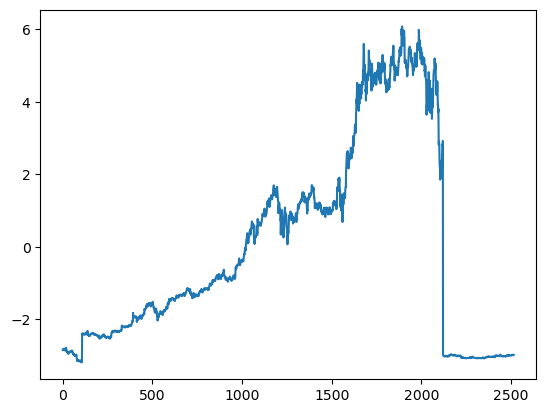

In [10]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

ko = pd.read_pickle('../data/nasdaq/AAPL.pkl')
pep = pd.read_pickle('../data/nasdaq/AMZN.pkl')

def regression_residuals(s1: pd.DataFrame, s2: pd.DataFrame) -> pd.DataFrame:
    x = s1[0]
    y = s2[0]

    # add a constant term
    x = sm.add_constant(x)
    print(y)
    print(x)

    model = sm.OLS(y, x)
    res = model.fit()

    return res.resid


residuals = regression_residuals(ko, pep)

print(residuals)

sns.lineplot(residuals)
plt.show()


## Performing the Dickey Fuller Test on the Time Series of Residuals

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test() -> float:
    res = adfuller(residuals)
    print(res[1])


adf_test()

0.6582875978194114


In [12]:
# now we do the two step engle granger test on all pairs from the NASDAQ 100

import os
from tqdm.notebook import tqdm

DATA_BASE = '../data/nasdaq/'
unprobed_files = os.listdir(DATA_BASE)

# only include mature companies,
# also makes OLS simpler

files = []
for file in unprobed_files:
    file_path = os.path.join(DATA_BASE, file)
    df = pd.read_pickle(file_path)

    prices = df[0]
    if len(prices) != 2516:
        continue

    files.append(file)

p_values = {}
for i in tqdm(range(len(files)), desc="Running ADF Test"):
    base_file = files[i]
    base_file_path = os.path.join(DATA_BASE, base_file)
    base_df = pd.read_pickle(base_file_path)
    base_ticker = base_file.split('.')[0]

    base_p_values = []
    for j in range(len(files)):
        aux_file = files[j]
        aux_file_path = os.path.join(DATA_BASE, aux_file)
        aux_df = pd.read_pickle(aux_file_path)

        try:
            residuals = regression_residuals(base_df, aux_df)
            adf = adfuller(residuals)
            p_value = adf[1]
        except:
            print(f'error on base: {i}, aux: {j}')
            p_value = 1

        base_p_values.append(p_value)

    p_values[base_ticker] = base_p_values

# show sns heatmap
heatmap_index = list(map(lambda f: f.split('.')[0], files))

heatmap_df = pd.DataFrame(p_values, index=heatmap_index)
heatmap_df.to_pickle('../data/adf.pkl')

Running ADF Test:   0%|          | 0/79 [00:00<?, ?it/s]

0       1.000000
1       0.981688
2       0.982530
3       0.966112
4       0.967165
          ...   
2511    1.375500
2512    1.380130
2513    1.381604
2514    1.376342
2515    1.363923
Name: 0, Length: 2516, dtype: float64
      const         0
0       1.0  1.000000
1       1.0  0.981688
2       1.0  0.982530
3       1.0  0.966112
4       1.0  0.967165
...     ...       ...
2511    1.0  1.375500
2512    1.0  1.380130
2513    1.0  1.381604
2514    1.0  1.376342
2515    1.0  1.363923

[2516 rows x 2 columns]
0       1.000000
1       0.994279
2       1.014482
3       1.020561
4       1.050957
          ...   
2511    1.527266
2512    1.522618
2513    1.542285
2514    1.534060
2515    1.547828
Name: 0, Length: 2516, dtype: float64
      const         0
0       1.0  1.000000
1       1.0  0.981688
2       1.0  0.982530
3       1.0  0.966112
4       1.0  0.967165
...     ...       ...
2511    1.0  1.375500
2512    1.0  1.380130
2513    1.0  1.381604
2514    1.0  1.376342
2515    1.0  1.3639

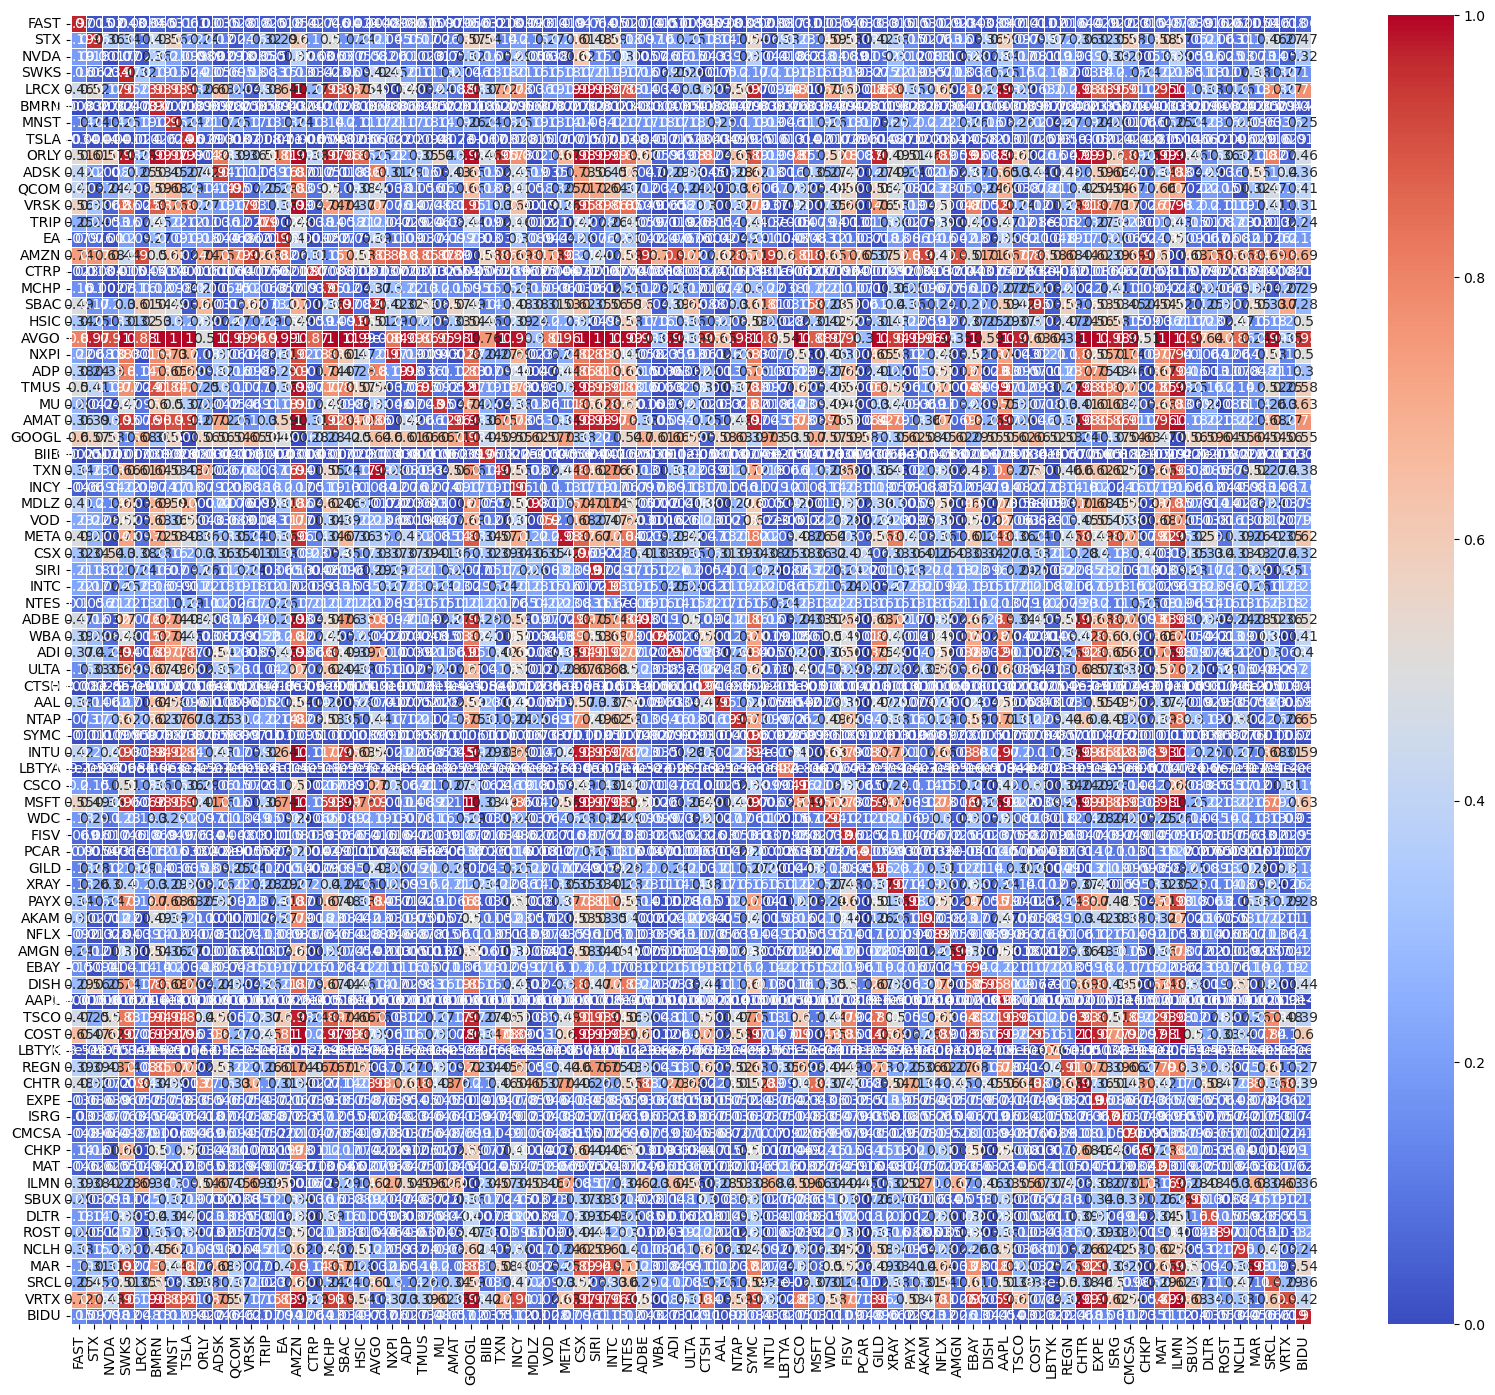

0       1.000000
1       0.994925
2       0.967193
3       0.979557
4       0.969641
          ...   
2511    0.351245
2512    0.348420
2513    0.346404
2514    0.349374
2515    0.348942
Name: 0, Length: 2516, dtype: float64
      const         0
0       1.0  1.000000
1       1.0  1.006258
2       1.0  1.007927
3       1.0  1.002295
4       1.0  1.016896
...     ...       ...
2511    1.0  0.734043
2512    1.0  0.735086
2513    1.0  0.744889
2514    1.0  0.742386
2515    1.0  0.738006

[2516 rows x 2 columns]
9.104296439449745e-05


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_df = pd.read_pickle('../data/adf.pkl')
heatmap_df = heatmap_df.iloc[:, :]

plt.figure(figsize=(20, 17))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# cointegration of TSCO with TSCO
tsco = pd.read_pickle('../data/nasdaq/XRAY.pkl')
amzn = pd.read_pickle('../data/nasdaq/AAPL.pkl')
tsco_residuals = regression_residuals(tsco, amzn)

tsco_adf = adfuller(tsco_residuals)
print(tsco_adf[1])


6241
['LBTYA', 'SRCL', 9.086582059505403e-12]
['LBTYK', 'TRIP', 1.3105402035729797e-10]
['LBTYA', 'TRIP', 5.084176839166351e-10]
['LBTYA', 'VOD', 6.200491773132773e-10]
['LBTYA', 'AAL', 1.3260701010442169e-09]
['LBTYA', 'WBA', 1.3453997747722444e-09]
['LBTYK', 'CTRP', 3.2804938726696073e-09]
['LBTYK', 'SRCL', 3.4009371474461266e-09]
['LBTYA', 'GILD', 7.19274144556965e-09]
['LBTYA', 'DISH', 9.87583603038182e-09]
['LBTYA', 'CTRP', 1.360130581575755e-08]
['AVGO', 'AVGO', 1.8987110386335802e-08]
['LBTYK', 'DISH', 3.195512777513321e-08]
['LBTYA', 'TMUS', 4.8899656818104295e-08]
['LBTYA', 'VRSK', 4.905558482434418e-08]
['LBTYA', 'ADP', 5.544732562984678e-08]
['LBTYK', 'AAL', 5.890949983601064e-08]
['LBTYK', 'VOD', 6.943269548467421e-08]
['LBTYK', 'WBA', 1.1004253590099323e-07]
['LBTYA', 'MDLZ', 1.880435106611319e-07]
['LBTYA', 'PAYX', 2.3653177688418847e-07]
['LBTYA', 'NCLH', 2.6880359240712536e-07]
['LBTYA', 'MSFT', 2.832051244745377e-07]
['LBTYA', 'HSIC', 2.93443383976145e-07]
['LBTYA', 'C

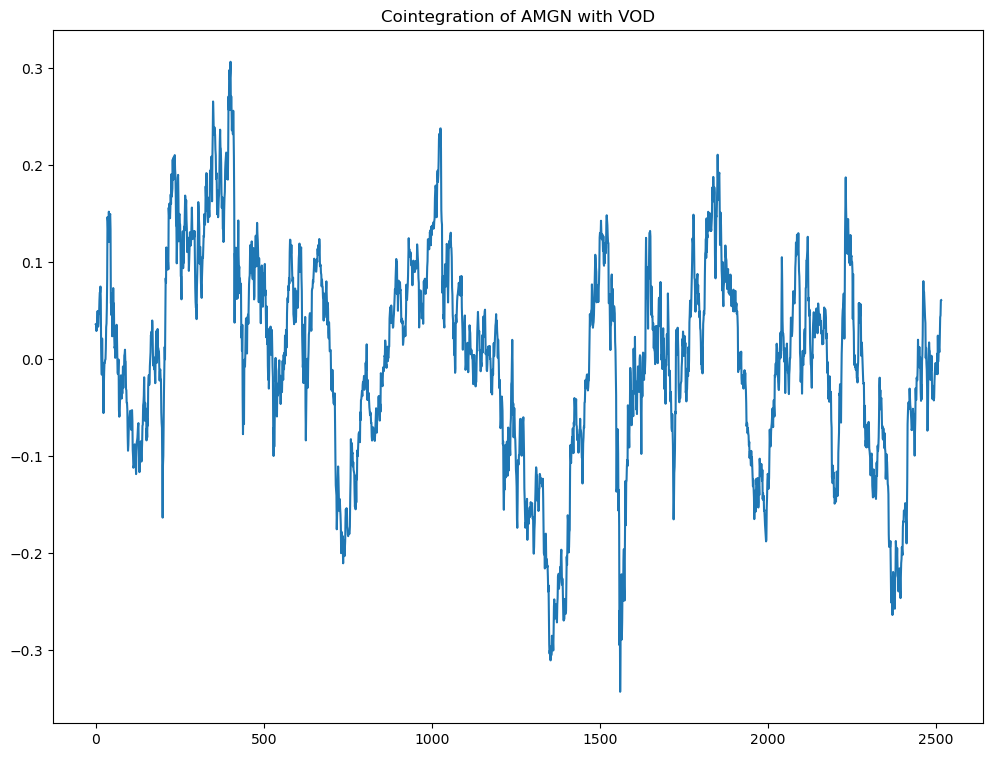

0       1.000000
1       0.996323
2       0.997395
3       0.977325
4       0.972116
          ...   
2511    3.613605
2512    3.614831
2513    3.625249
2514    3.650682
2515    3.637965
Name: 0, Length: 2516, dtype: float64
      const         0
0       1.0  1.000000
1       1.0  1.011717
2       1.0  1.000962
3       1.0  0.992480
4       1.0  1.019937
...     ...       ...
2511    1.0  2.448409
2512    1.0  2.484435
2513    1.0  2.487758
2514    1.0  2.517314
2515    1.0  2.517139

[2516 rows x 2 columns]


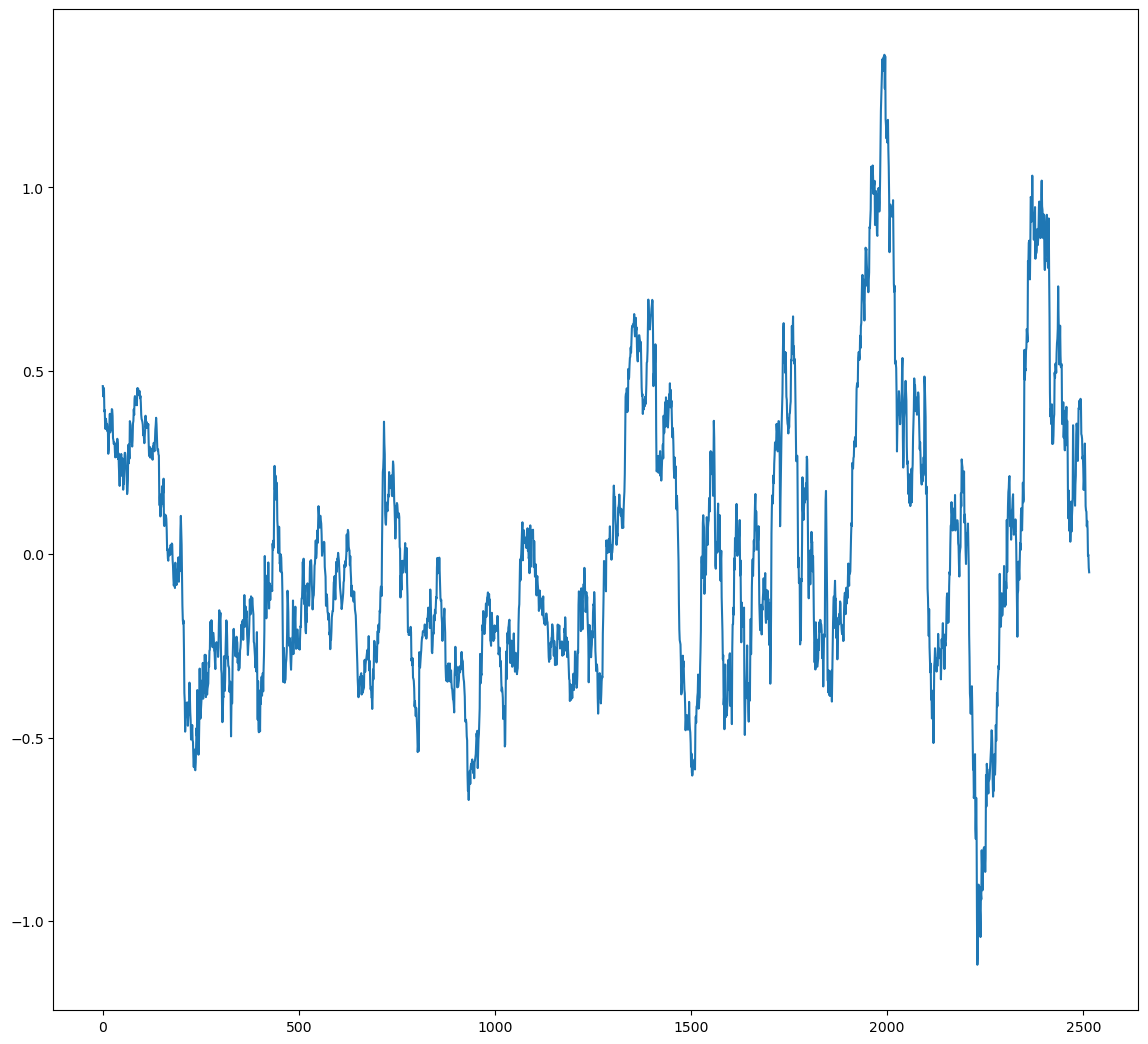

In [16]:
import os

def get_residuals(s1, s2):
    s1_df_path = os.path.join(DATA_BASE, s1 + '.pkl')
    s2_df_path = os.path.join(DATA_BASE, s2 + '.pkl')

    s1_df = pd.read_pickle(s1_df_path)
    s2_df = pd.read_pickle(s2_df_path)

    residuals = regression_residuals(s1_df, s2_df)
    return residuals


# get most cointegrated stocks
stack = heatmap_df.stack()
print(len(stack))

stack = stack.reset_index() \
             .sort_values(by=0) \
             .values.tolist()

for item in stack:
    print(item)

# good pairs: (AMGN, WBA), (AMGN, VOD)

residuals = get_residuals('AMGN', 'VOD')
plt.figure(figsize=(12, 9))
sns.lineplot(residuals)
plt.title("Cointegration of AMGN with VOD")
plt.show()

residuals = get_residuals('AMGN', 'VRSK')
plt.figure(figsize=(14, 13))
sns.lineplot(residuals)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 3.823e+04
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:04:58   Log-Likelihood:                 1316.0
No. Observations:                2516   AIC:                            -2628.
Df Residuals:                    2514   BIC:                            -2616.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1561      0.006     27.298      0.0

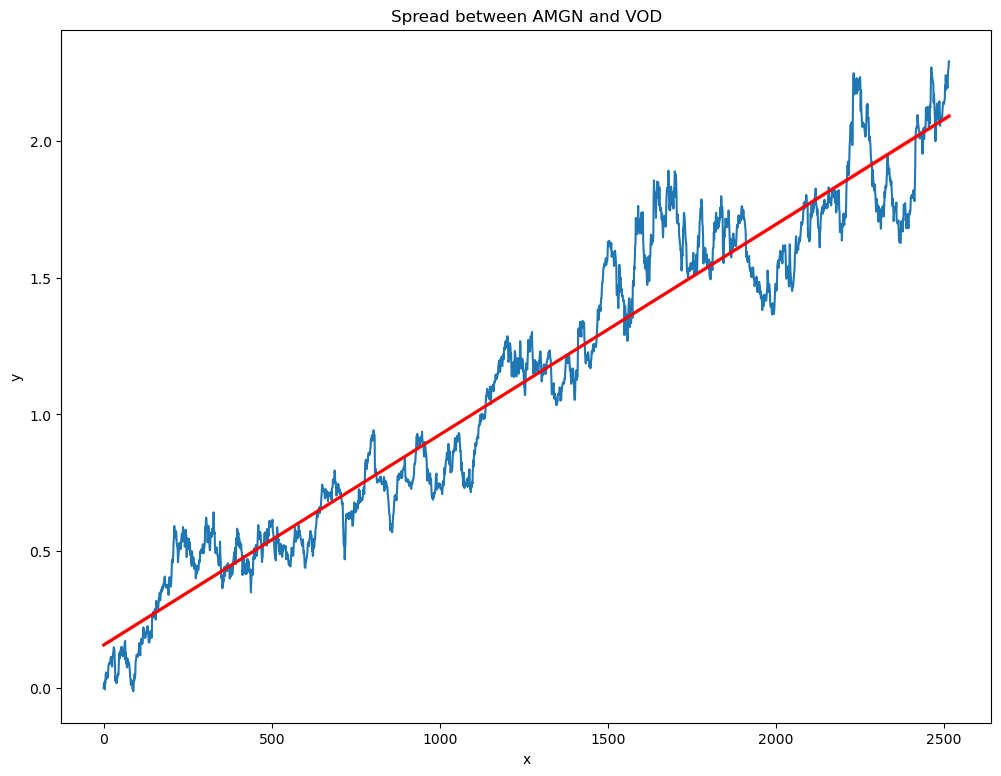

In [17]:
# Examine differences between spreads and residuals

amgn_df_path = os.path.join(DATA_BASE, 'AMGN.pkl')
amgn_df = pd.read_pickle(amgn_df_path)

vod_df_path = os.path.join(DATA_BASE, 'VOD.pkl')
vod_df = pd.read_pickle(vod_df_path)

spreads = amgn_df - vod_df

spread_df = pd.DataFrame({
    'x': range(len(spreads)),
    'y': spreads[0]
})

# spread_df['sma'] = spread_df['y'].rolling(window=180).mean()

# actually get regression outputs
x = spread_df['x']
y = spread_df['y']

x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()

print(res.summary())

plt.figure(figsize=(12, 9))

sns.lineplot(data=spread_df, x='x', y='y')
# sns.lineplot(data=spread_df, x='x', y='sma')
sns.regplot(data=spread_df, x='x', y='y', line_kws={ 'color': 'red' }, scatter=False)

plt.title("Spread between AMGN and VOD")
plt.show()